<h1 style="text-align:center;">Лабораторная работа № 1 </h1>
<h2 style="text-align:center;"><span>Разведочный анализ данных с помощью PySpark</span></h2>

<h4 >1. Разведочный анализ выбранного датасета с определением типов признаков в датасете </h4>

<span>  1.1. Инициализации базовой функциональности PySpark</span>

In [41]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .master("local[*]")\
    .appName('SOBD-22')\
    .getOrCreate()

<span>1.2. Чтение данных из файла формата CSV и определение типов признаков</span>

In [42]:
data = spark.read.csv(
    'WeatherEvents_Jan2016-Dec2021.csv', 
    sep=',', 
    header=True,
    inferSchema=True
    )
data.printSchema()

root
 |-- EventId: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- TimeZone: string (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- LocationLat: double (nullable = true)
 |-- LocationLng: double (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: integer (nullable = true)



In [43]:
data.show(10)

+-------+----+--------+-------------------+-------------------+-------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|EventId|Type|Severity|          StartTime|            EndTime|Precipitation|   TimeZone|AirportCode|LocationLat|LocationLng|    City|  County|State|ZipCode|
+-------+----+--------+-------------------+-------------------+-------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|    W-1|Snow|   Light|2016-01-06 23:14:00|2016-01-07 00:34:00|          0.0|       null|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-2|Snow|   Light|2016-01-07 04:14:00|2016-01-07 04:54:00|          0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-3|Snow|   Light|2016-01-07 05:54:00|2016-01-07 15:34:00|         0.03|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-4|Snow|   Light|2016-01-08 05:34:00|2016-01-0

<h4 >2. Разведочный анализ выбранного датасета с определением пропущенных значений и их устранением </h4>

<span>2.1. Определение процентного соотношения пропущенных значений</span>

In [44]:
import numpy as np
import pandas as pd
df = pd.read_csv('WeatherEvents_Jan2016-Dec2021.csv')
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

EventId - 0%
Type - 0%
Severity - 0%
StartTime - 0%
EndTime - 0%
Precipitation - 0%
TimeZone - 0%
AirportCode - 0%
LocationLat - 0%
LocationLng - 0%
City - 0%
County - 0%
State - 0%
ZipCode - 1%


<span>2.2. Удаление строк с пропущенными значениями</span>

In [45]:
data.na.drop().show(10)

+-------+----+--------+-------------------+-------------------+-------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|EventId|Type|Severity|          StartTime|            EndTime|Precipitation|   TimeZone|AirportCode|LocationLat|LocationLng|    City|  County|State|ZipCode|
+-------+----+--------+-------------------+-------------------+-------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|    W-2|Snow|   Light|2016-01-07 04:14:00|2016-01-07 04:54:00|          0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-3|Snow|   Light|2016-01-07 05:54:00|2016-01-07 15:34:00|         0.03|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-4|Snow|   Light|2016-01-08 05:34:00|2016-01-08 05:54:00|          0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-5|Snow|   Light|2016-01-08 13:54:00|2016-01-0

<h4 >3. Разведочный анализ выбранного датасета с определением выбросов и их устранением </h4>

<span>3.1. Обнаружение выбросов с помощью коробчатой диаграммы</span>

<AxesSubplot:>

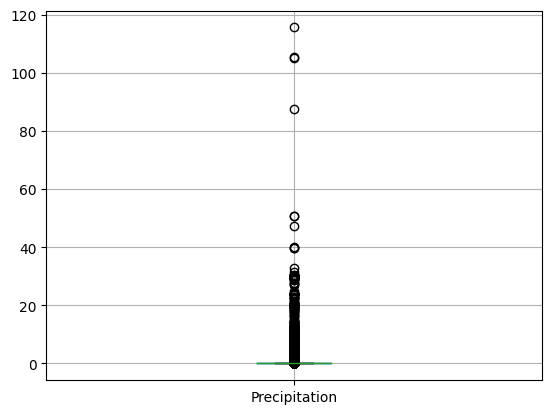

In [46]:
df.boxplot(column=['Precipitation'])

<AxesSubplot:>

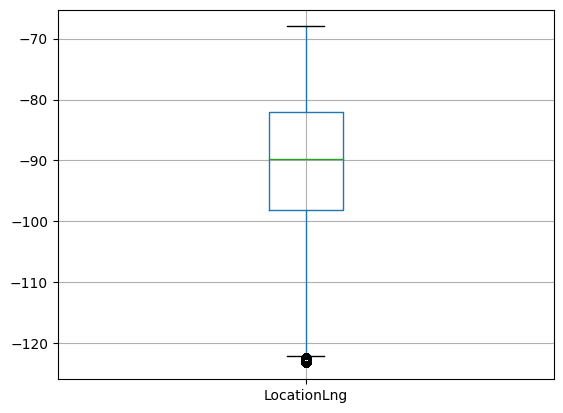

In [47]:
df.boxplot(column=['LocationLng'])

<span>3.2. Нахождение 25% и 75% квартилей, межквартильного диапазона</span>

<AxesSubplot:>

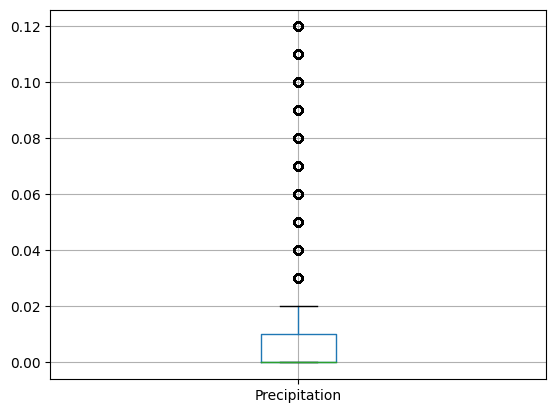

In [48]:
Q1 =  df['Precipitation'].quantile(0.25)
Q3 = df['Precipitation'].quantile(0.75)
IQR = Q3 - Q1

df_IQR = df[(df['Precipitation'] > (Q1-1.5*IQR)) & (df['Precipitation'] < (Q3+1.5*IQR))]
df_IQR.boxplot(column="Precipitation")

<span>3.3. Удаление строк с выбросами</span>

In [49]:
print("До удаления: ", df.shape)

upper = np.where(df['Precipitation'] >= (Q3+1.5*IQR))

lower = np.where(df['Precipitation'] <= (Q1-1.5*IQR))
 
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("После удаления: ", df.shape)

До удаления:  (1048575, 14)
После удаления:  (886056, 14)


<h4 >4. Разведочный анализ выбранного датасета с расчетом статистических показателей признаков (средних, квартилей и т.д.) </h4>

In [50]:
data.describe().show()

+-------+--------+-------+--------+-------------------+----------+-----------+------------------+------------------+--------+-------------+-------+-----------------+
|summary| EventId|   Type|Severity|      Precipitation|  TimeZone|AirportCode|       LocationLat|       LocationLng|    City|       County|  State|          ZipCode|
+-------+--------+-------+--------+-------------------+----------+-----------+------------------+------------------+--------+-------------+-------+-----------------+
|  count| 1048575|1048575| 1048575|            1048575|   1048574|    1048575|           1048575|           1048575| 1043886|      1048575|1048575|          1038036|
|   mean|    null|   null|    null|0.09202718928068619|      null|       null|39.105779139682724|-92.10921699430989|    null|         null|   null|52116.73149004466|
| stddev|    null|   null|    null| 0.5717147867882701|      null|       null|5.2113762072998435|13.444456791405953|    null|         null|   null|25977.04062243807|
|   

In [51]:
df['Precipitation'].describe()

count    886056.000000
mean          0.014041
std           0.029194
min           0.000000
25%           0.000000
50%           0.000000
75%           0.010000
max           0.120000
Name: Precipitation, dtype: float64

<h4 >5. Разведочный анализ выбранного датасета с визуализацией распределения наиболее важных признаков </h4>

<AxesSubplot:>

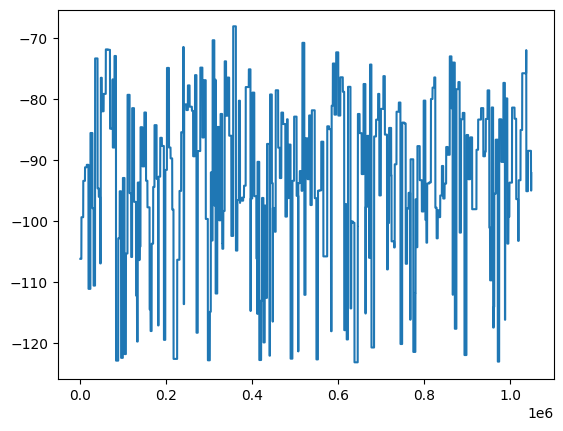

In [56]:
df.LocationLng.plot()

<AxesSubplot:>

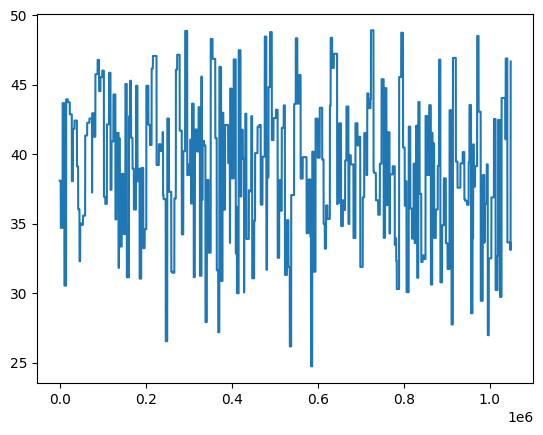

In [53]:
df.LocationLat.plot()

<AxesSubplot:>

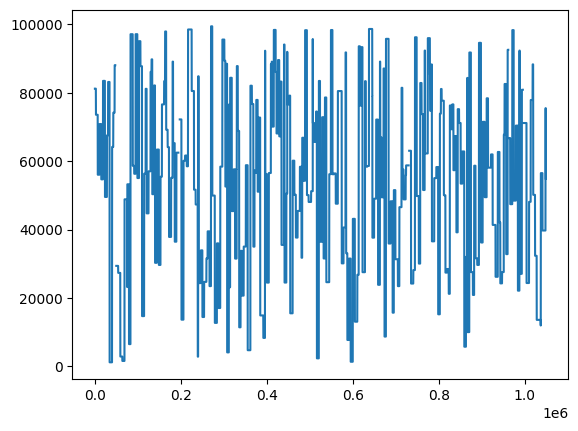

In [54]:
df.ZipCode.plot()

<h4 >5. Разведочный анализ выбранного датасета с определением корреляций между признаками </h4>

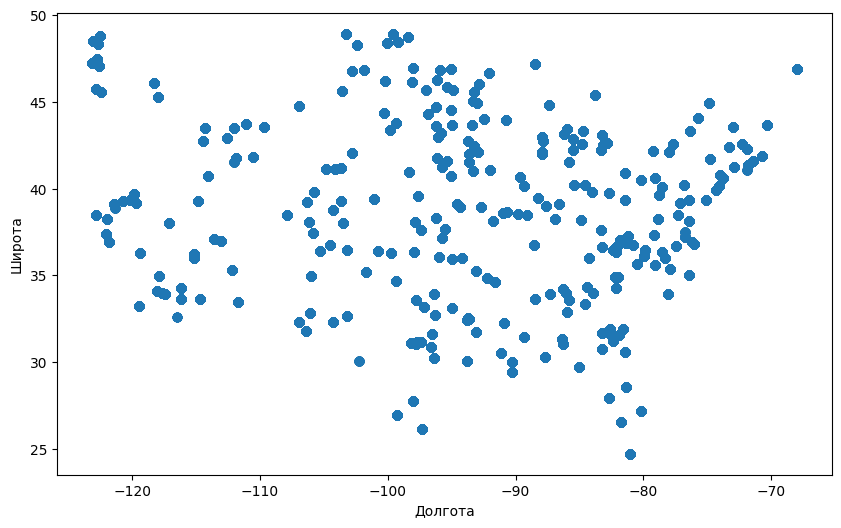

In [65]:
import matplotlib.pyplot as plt
# Scatter plot
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(df['LocationLng'], df['LocationLat'])

# x-axis label
ax.set_xlabel('Долгота')

# y-axis label
ax.set_ylabel('Широта')
plt.show()
